In [1]:
import os
from datetime import datetime
import pandas as pd
#Below runs the code on CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.set_option("display.max_rows", None, "display.max_columns", None)

import csv
from functions import *

In [2]:
start_time = datetime.now()
close_price = []
volume=[]
split_time = 2000

time_steps=[]
index = 0
with open(r'D:/Downloads/500038.csv') as file:
    csv_reader = csv.reader(file, delimiter=',')
    next(csv_reader)
    #sel_rows = [row for idx, row in enumerate(csv_reader) if idx>2]
    for row in csv_reader:
        index +=1
        time_steps.append(index)
        close_price.append(float(row[4]))# If float not added then order missing in plots as its string
        volume.append(float(row[6]))

In [3]:
time_steps = np.array(time_steps)
close_price = np.array(close_price).reshape(-1, 1)
close_price = normalize(close_price)
test_close = close_price[split_time:]# Moved here so that EMA not present in this df and this is used only for mae

close_price = add_ema(close_price, 'close_price')
totalVars = close_price.shape[1]
train_volume = volume[:split_time]
train_close = close_price[:split_time]

train_data = np.concatenate([train_close], axis=1)

In [4]:
window_size = 10
batch_size = 16
shuffle_buffer_size = 1000

train_ds = windowed_dataset(train_data, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='causal',input_shape=[None, totalVars]),
    tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(metrics=['mae'], loss=tf.keras.losses.Huber(), optimizer='adam')
history = model.fit(train_ds, epochs=50)
model.save('stockMulti.h5')

Epoch 1/50
125/125 [==============================] - 3s 8ms/step - loss: 0.0031 - mae: 0.0542
Epoch 2/50
125/125 [==============================] - 1s 8ms/step - loss: 3.6828e-04 - mae: 0.0213
Epoch 3/50
125/125 [==============================] - 1s 7ms/step - loss: 3.7197e-04 - mae: 0.0208
Epoch 4/50
125/125 [==============================] - 1s 8ms/step - loss: 4.2331e-04 - mae: 0.0225
Epoch 5/50
125/125 [==============================] - 1s 8ms/step - loss: 2.9897e-04 - mae: 0.0189
Epoch 6/50
125/125 [==============================] - 1s 9ms/step - loss: 2.8775e-04 - mae: 0.0188
Epoch 7/50
125/125 [==============================] - 1s 8ms/step - loss: 2.7845e-04 - mae: 0.0177
Epoch 8/50
125/125 [==============================] - 1s 8ms/step - loss: 2.5256e-04 - mae: 0.0171
Epoch 9/50
125/125 [==============================] - 1s 8ms/step - loss: 2.4523e-04 - mae: 0.0170
Epoch 10/50
125/125 [==============================] - 1s 9ms/step - loss: 2.4915e-04 - mae: 0.0169
Epoch 11/50
1

In [5]:
model = tf.keras.models.load_model('stockMulti.h5')

In [6]:
#min_max_long = [-0.02664521796316971, 0.09861810934800397]
#min_max_short = [-0.022278188867550397, 0.04288502990299048]
rnn_forecast = close_price[:, 0][split_time - window_size:split_time]
train_open_conc = close_price[:,0][:split_time-window_size].reshape(-1,1)
for time in range((len(close_price) - split_time)):
    close_ema = add_ema(np.concatenate([train_open_conc, rnn_forecast.reshape(-1,1)],axis=0), 'close_price')
    close_test = close_ema[split_time+time-window_size:split_time+time].reshape(-1, totalVars)# 1 added for volume so removed here
    input = close_test.reshape(-1, window_size, totalVars)
    pred_out = model.predict(input)
    rnn_forecast = np.append(rnn_forecast, pred_out)
rnn_forecast = rnn_forecast[window_size:].reshape(-1,1)
forecast = np.array(rnn_forecast)[:, 0]

In [13]:
train_open_conc[-10:]

array([[0.29770142],
       [0.29415832],
       [0.29505687],
       [0.30141939],
       [0.29985096],
       [0.29799197],
       [0.29747275],
       [0.3001442 ],
       [0.28968169],
       [0.28989691]])

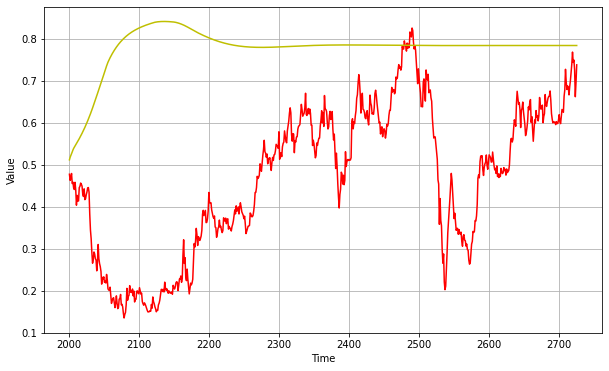

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plot_series(time_steps[split_time:], test_close, 'r')
plot_series(time_steps[split_time:], forecast, 'y')

In [5]:
rnn_forecast = close_price[:, 0][split_time - window_size:split_time]
close_price_ema = close_price[:, 1:][split_time - window_size:]
#test_volume = volume[split_time - window_size:]
for time in range((len(close_price) - split_time)):
    close_test = rnn_forecast[time:time + window_size].reshape(-1,1)
    #vol_test = test_volume[time:time + window_size]
    close_price_ema_input = close_price_ema[time:time + window_size]
    input = np.concatenate([close_test, close_price_ema_input], axis=1).reshape(-1, window_size, totalVars)
    pred_out = model.predict(input)
    rnn_forecast = np.append(rnn_forecast, pred_out)
rnn_forecast = rnn_forecast[window_size:].reshape(-1,1)
forecast = np.array(rnn_forecast)[:, 0]

In [15]:
close_price[3980:3990]

array([[0.29770142, 0.32010906, 0.31289844, 0.3069217 ],
       [0.29415832, 0.31985084, 0.31216353, 0.30570614],
       [0.29505687, 0.31960414, 0.31149268, 0.30469192],
       [0.30141939, 0.3194232 , 0.31109765, 0.30438025],
       [0.29985096, 0.31922845, 0.3106566 , 0.30394889],
       [0.29799197, 0.31901714, 0.31015995, 0.30338157],
       [0.29747275, 0.31880277, 0.30966241, 0.30281882],
       [0.3001442 , 0.31861711, 0.30928915, 0.30256409],
       [0.28968169, 0.31832919, 0.30852023, 0.3013372 ],
       [0.28989691, 0.31804629, 0.3077899 , 0.30024765]])

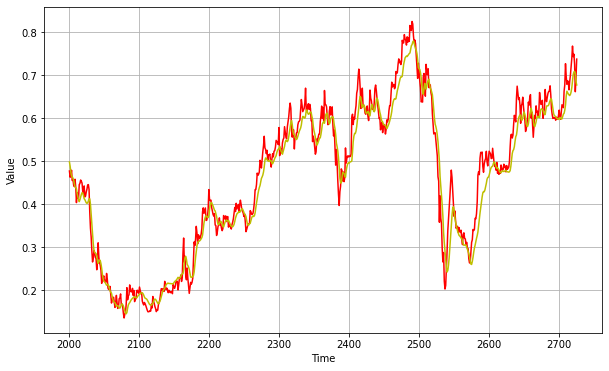

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plot_series(time_steps[split_time:], test_close, 'r')
plot_series(time_steps[split_time:], forecast, 'y')